In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import h5py as h5

In [7]:
file = h5.File('../output/large/lcdm.h5')
# file.close()

In [3]:
p = file["potential"][:]

In [9]:
file.close()

In [5]:
def polygon_to_triangles(p):
    return np.c_[np.repeat(p[0], p.size - 2), p[1:-1], p[2:]]

class Mesh:
    def __init__(self, h5_group):
        """Initialize a mesh from a group in a HDF5 file."""
        self.vertices = h5_group['vertices'][:].astype('float64')
        data = h5_group['data'][:]
        sizes = h5_group['sizes'][:]
        self.info = h5_group['info'][:].astype('float64')
        i1 = np.cumsum(sizes)
        i0 = np.r_[[0], i1[:-1]].astype(np.uint)
        self.polygons = [data[i:j] for i, j in np.c_[i0, i1]]
    
    @property
    def triangles(self):
        return np.concatenate([polygon_to_triangles(p) for p in self.polygons])

In [8]:
nodes = [file[str(s)]["nodes"][:] for s in range(3)]

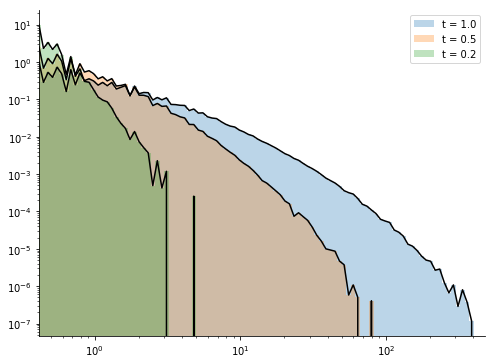

In [10]:
bins = np.logspace(-0.4, 2.7, 100)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_xscale("log")
ax.set_yscale("log")

x = np.sqrt(bins[:-1]) * np.sqrt(bins[1:])
t = [0.2, 0.5, 1.0]
for i in range(3)[::-1]:
    hist = ax.hist(
        nodes[i][np.where(nodes[i]['node_type'] == 4)]['mass'],
        bins=bins,
        density=True,
        alpha=0.3,
        label="t = {}".format(t[i]))
    ax.plot(x, hist[0], c='k')
ax.legend()
ax.set_xlim(x[0], x[-1])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.savefig('mass-functions.pdf', bbox_inches='tight')

In [60]:
i = 2
bins = np.logspace(0.5, 2.0, 100)
m = nodes[i][np.where(nodes[i]['node_type'] == 4)]['mass']
x = np.sqrt(bins[:-1]) * np.sqrt(bins[1:])
h = np.histogram(m, bins=bins, density=True)

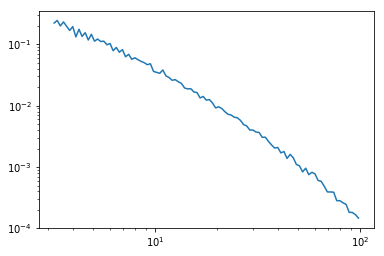

In [61]:
plt.loglog(x, h[0])

In [62]:
from scipy.optimize import least_squares

def schechter(A, x_star, gamma):
    def f(x):
        y = x / x_star
        return A * y**gamma * np.exp(-y)
    
    return f

def q(pars, f, x, y):
    return f(*pars)(x) - y

fit = least_squares(q, np.ones(3), args=(schechter, x, h[0]))

In [63]:
fit_fn = schechter(*fit.x)

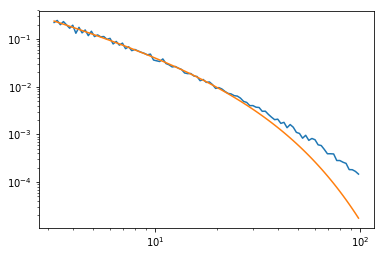

In [64]:
#bins = np.logspace(-0.4, 2.2, 100)
# x = np.sqrt(bins[:-1]) * np.sqrt(bins[1:])
# h = np.histogram(m, bins=bins)

fig, ax = plt.subplots(1, 1)
ax.loglog(x, h[0])
ax.loglog(x, fit_fn(x))
# ax.set_ylim(1e2, 1e4)